Setup complete.
Model created: GeometricBrownianMotion({'S0': 100, 'mu': 0.07, 'sigma': 0.2})
Simulated path shape: (253, 10)


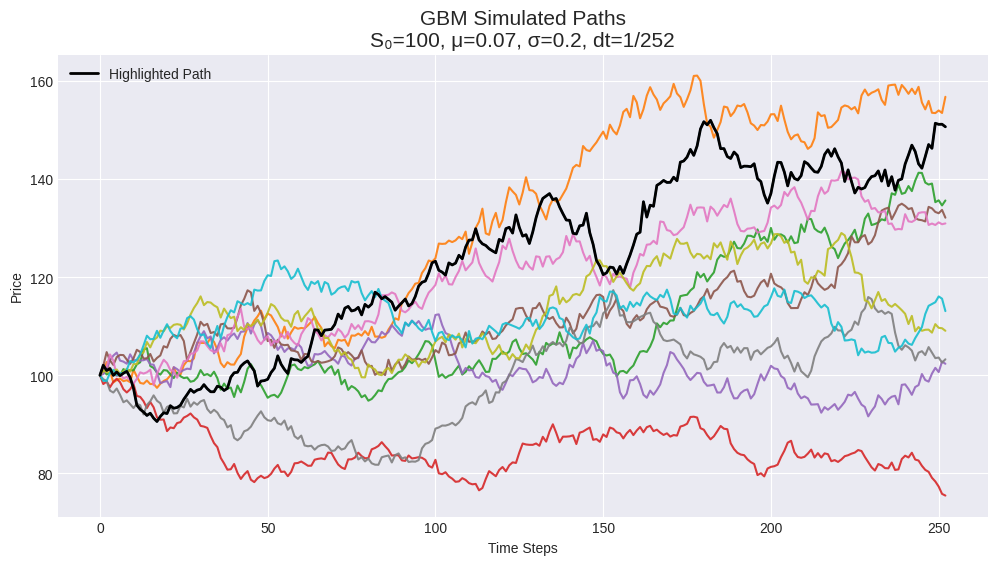

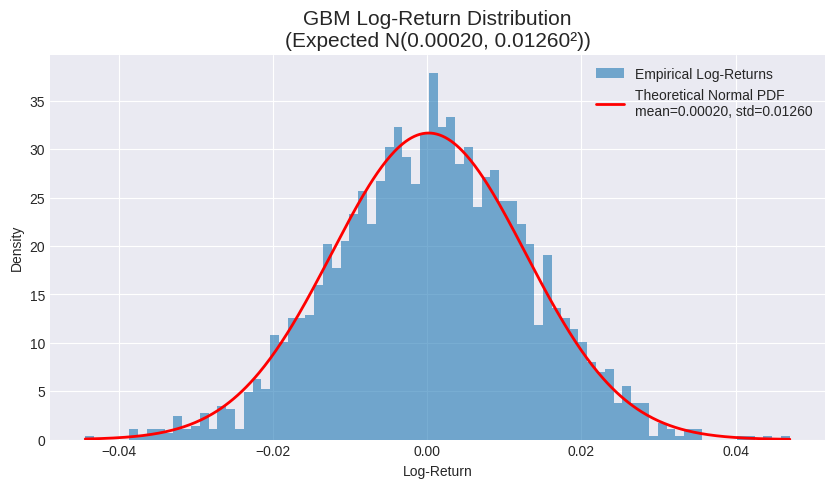

<Figure size 600x600 with 0 Axes>

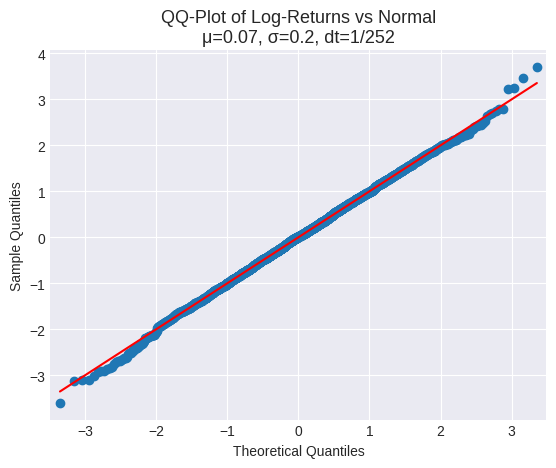

===== GBM Validation Stats =====
Theoretical mean : 0.000198
Empirical mean   : 0.000674
Theoretical std  : 0.012599
Empirical std    : 0.012499



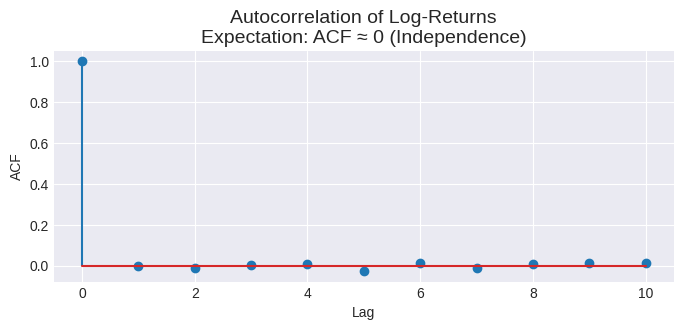

First 5 ACF values: [ 1.         -0.00333686 -0.00946226  0.00352128  0.0103094 ]
ACF should be close to 0 for all lags.

===== Normality Tests =====
Kolmogorov–Smirnov p-value : 0.0737
Jarque–Bera p-value        : 0.4675
Shapiro–Wilk p-value       : 0.5707

Interpretation:
- p-value > 0.05 → cannot reject normality (GOOD)
- p-value < 0.05 → deviation likely due to finite sample or heavy tails


In [33]:
# ============================================================
# Imports
# ============================================================
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy.stats import norm, kstest, shapiro, jarque_bera
import statsmodels.api as sm

sys.path.insert(0, os.path.abspath('../src'))
from models.gbm import GeometricBrownianMotion

plt.style.use('seaborn-v0_8-darkgrid')
print("Setup complete.")

# ============================================================
# 1. Model Creation
# ============================================================
gbm_params = {
    'S0': 100,      # Start price
    'mu': 0.07,     # Annual drift
    'sigma': 0.2    # Annual volatility
}

gbm_model = GeometricBrownianMotion(**gbm_params)
print(f"Model created: {gbm_model}")

# ============================================================
# 2. Simulating GBM
# ============================================================
T = 1          # 1 year
dt = 1/252     # daily
n_paths = 10

sim_paths = gbm_model.simulate(T, dt, n_paths)
print(f"Simulated path shape: {sim_paths.shape}")

# ============================================================
# 3. Plot simulated paths
# ============================================================
plt.figure(figsize=(12, 6))
plt.plot(sim_paths, alpha=0.9)
plt.plot(sim_paths[:, 0], color='black', linewidth=2.0, label="Highlighted Path")

plt.title(
    f"GBM Simulated Paths\n"
    f"S₀={gbm_params['S0']}, μ={gbm_params['mu']}, σ={gbm_params['sigma']}, dt=1/252",
    fontsize=15
)
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()

# ============================================================
# 4. Log-return validation
# ============================================================
log_returns = np.log(sim_paths[1:] / sim_paths[:-1]).flatten()

# theoretical mean & std of log-returns
theo_mean = (gbm_params['mu'] - 0.5 * gbm_params['sigma']**2) * dt
theo_std = gbm_params['sigma'] * np.sqrt(dt)

# ============================================================
# 5. Histogram + Theoretical PDF
# ============================================================
plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=80, density=True, alpha=0.6, label="Empirical Log-Returns")

x_vals = np.linspace(log_returns.min(), log_returns.max(), 500)
plt.plot(
    x_vals,
    norm.pdf(x_vals, theo_mean, theo_std),
    'r-', lw=2,
    label=f"Theoretical Normal PDF\nmean={theo_mean:.5f}, std={theo_std:.5f}"
)

plt.title(
    f"GBM Log-Return Distribution\n"
    f"(Expected N({theo_mean:.5f}, {theo_std:.5f}²))",
    fontsize=15
)
plt.xlabel("Log-Return")
plt.ylabel("Density")
plt.legend()
plt.show()

# ============================================================
# 6. QQ Plot
# ============================================================
plt.figure(figsize=(6, 6))
sm.qqplot(log_returns, line='s', dist=norm, fit=True)
plt.title(
    f"QQ-Plot of Log-Returns vs Normal\nμ={gbm_params['mu']}, σ={gbm_params['sigma']}, dt=1/252",
    fontsize=13
)
plt.show()

# ============================================================
# 7. Empirical vs Theoretical Stats
# ============================================================
emp_mean = np.mean(log_returns)
emp_std = np.std(log_returns)

print("===== GBM Validation Stats =====")
print(f"Theoretical mean : {theo_mean:.6f}")
print(f"Empirical mean   : {emp_mean:.6f}")
print(f"Theoretical std  : {theo_std:.6f}")
print(f"Empirical std    : {emp_std:.6f}\n")

# ============================================================
# 8. ACF Check (Independence Test)
# ============================================================
acf_vals = sm.tsa.acf(log_returns, nlags=10)

plt.figure(figsize=(8, 3))
plt.stem(range(len(acf_vals)), acf_vals)
plt.title(
    f"Autocorrelation of Log-Returns\n"
    f"Expectation: ACF ≈ 0 (Independence)",
    fontsize=14
)
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.show()

print("First 5 ACF values:", acf_vals[:5])
print("ACF should be close to 0 for all lags.\n")

# ============================================================
# 9. Normality Tests
# ============================================================
ks_p = kstest(log_returns, 'norm', args=(theo_mean, theo_std)).pvalue
jb_stat, jb_p = jarque_bera(log_returns)
sw_p = shapiro(log_returns)[1]

print("===== Normality Tests =====")
print(f"Kolmogorov–Smirnov p-value : {ks_p:.4f}")
print(f"Jarque–Bera p-value        : {jb_p:.4f}")
print(f"Shapiro–Wilk p-value       : {sw_p:.4f}\n")

print("Interpretation:")
print("- p-value > 0.05 → cannot reject normality (GOOD)")
print("- p-value < 0.05 → deviation likely due to finite sample or heavy tails")
